**Set System Path**

In [1]:
import sys
import os

sys_path = os.path.dirname(os.getcwd())
print(sys_path)
sys.path.append(sys_path)
os.chdir(sys_path)

/Users/shikaiyi/Desktop/Ncku/MedicalImage/final


**Import Tensorflow & Varify GPU**
- [MacOS](https://medium.com/geekculture/installing-tensorflow-on-apple-silicon-84a28050d784)

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if not device_name:
    print("GPU device not found")
else:
    print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


2024-01-04 16:15:00.246054: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-04 16:15:00.246077: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-04 16:15:00.246081: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-04 16:15:00.246282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-04 16:15:00.246299: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


**Packages and data preprocessing**

In [3]:
import os 
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm
from glob import glob

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
X_train = pd.read_csv('data/Training_Set/RFMiD_Training_Labels.csv')
X_val = pd.read_csv('data/Evaluation_Set/RFMiD_Validation_Labels.csv')
X_test = pd.read_csv('data/Test_Set/RFMiD_Testing_Labels.csv')

In [5]:
X_train.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train = X_train[['ID', 'BRVO']][:100]
X_val = X_val[['ID', 'BRVO']][:20]
X_test = X_test[['ID', 'BRVO']][:20]

In [7]:
X_train.describe()
# No missing value

,ID,BRVO
count,100.000000,100.000000
mean,50.500000,0.020000
std,29.011492,0.140705
min,1.000000,0.000000
25%,25.750000,0.000000
50%,50.500000,0.000000
75%,75.250000,0.000000
max,100.000000,1.000000


In [8]:
# reconstituion link image + drop ID feature
X_train['filename'] = X_train.apply(lambda x : "data/Training_Set/Training/" + str(x['ID']) + ".png", axis=1)
X_val['filename'] = X_val.apply(lambda x : "data/Evaluation_Set/Validation/" + str(x['ID']) + ".png", axis=1)
X_test['filename'] = X_test.apply(lambda x : "data/Test_Set/Test/" + str(x['ID']) + ".png", axis=1)

X_train = X_train.drop('ID', axis=1)
X_val = X_val.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

In [9]:
print(X_train.head(1))
print(X_train.shape)

   BRVO                          filename
0     0  data/Training_Set/Training/1.png
(100, 2)


In [10]:
# datasets
X_train_img = X_train['filename']
X_val_img = X_val['filename']
y_train = X_train.drop(['filename'], axis=1)
y_val = X_val.drop(['filename'], axis=1)

print('shape of X_train:', X_train_img.shape)
print('shape of Validation:', X_val_img.shape)
print('shape of y_train:', y_train.shape)
print('shape of y_val:', y_val.shape)

shape of X_train: (100,)
shape of Validation: (20,)
shape of y_train: (100, 1)
shape of y_val: (20, 1)


## Preprocessing images

In [11]:
IMG_SHAPE = (300, 450)
BATCH_SIZE = 64

In [23]:
from retina_features.bloodvessels import extract_bv

def erase_bv(color_org_img, gray_bv_img, inpaint_radius=3):
    inpaint_mask = cv2.bitwise_not(np.array(gray_bv_img))
    inpainted_img = np.zeros_like(color_org_img)

    # Apply inpainting to each channel of the color image
    for i in range(3):  # Assuming color_org_img has 3 channels (RGB)
        inpainted_img[:, :, i] = cv2.inpaint(color_org_img[:, :, i], inpaint_mask, inpaint_radius, cv2.INPAINT_TELEA)

    return inpainted_img

def extract_bv_wrapper(org_img):
    org_img_np = org_img.numpy()
    bv_img_np = extract_bv(org_img_np)

    inpainted_img_np = erase_bv(org_img_np, bv_img_np)

    if len(inpainted_img_np.shape) == 2:
        inpainted_img_np = np.stack((inpainted_img_np,) * 3, axis=-1)

    return tf.convert_to_tensor(inpainted_img_np, dtype=tf.float32)

In [24]:
@tf.function

def scale_down(img):
    img = tf.cast(img, dtype=tf.float32)
    img = tf.image.resize(img, (300, 450), method='nearest')
    img = (img / 255)
    return img

def preprocessing_data(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)

    img = tf.py_function(extract_bv_wrapper, [img], tf.float32)
    img.set_shape([None, None, 3])

    img = scale_down(img)
    return img

In [26]:
# Datasets preprocessing
AUTO = tf.data.experimental.AUTOTUNE

y_train = np.array(y_train).astype('float32')
y_val = np.array(y_val).astype('float32')

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_img, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_img, y_val))

dataset_train=(dataset_train
               .shuffle(1000)
               .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
               .batch(BATCH_SIZE, drop_remainder=True)
               .prefetch(AUTO)
               )

dataset_val=(dataset_val
             .map(lambda x, y: [preprocessing_data(x), y], num_parallel_calls=AUTO)
             .batch(BATCH_SIZE, drop_remainder=True)
             .prefetch(AUTO)
             )


print(dataset_train)
print(dataset_val)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 300, 450, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 300, 450, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, 1), dtype=tf.float32, name=None))>


In [21]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis('off')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


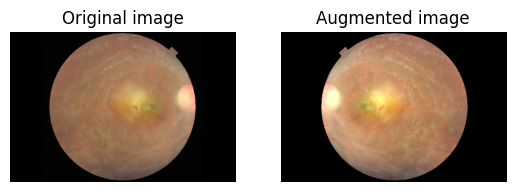

In [27]:
image, label = next(iter(dataset_train))
image, label = image.numpy()[0], label.numpy()[0]


flipped = tf.image.flip_left_right(image)
flipped =  tf.image.adjust_contrast(flipped, 1.35)
visualize(image, flipped)

In [28]:
# API keras preparation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, Activation, MaxPool2D, Dense, Flatten, GlobalAvgPool2D
from keras import backend as K
from tensorflow.keras.applications import VGG16
vgg16 = VGG16()

#for layer in xception.layers:
#    print(layer.name, layer)

## Global architecture VGG16:
________________________________________________________________________________
<img src="https://datascientest.com/wp-content/uploads/2021/04/illu_VGG-02.png" alt="data2" align="top" style="width: 800px;">


## Classification model

In [29]:
shape = (300, 450, 3)

def Layers(inputs, trainable=False):
    global vgg16_model
    vgg16_model = VGG16(weights='imagenet',
                        include_top=False,
                        input_tensor=inputs)
    
    if trainable == True:
        for layer in vgg16_model.layers:
            layer.trainable = True
            
    else:
        vgg16_model.trainable = False
            
    return vgg16_model.output
    
        
def Build_VGG16(trainable=False):
    
    inputs = Input(shape=shape)
    vgg16 = Layers(inputs, trainable)

    conv1 = Flatten()(vgg16_model.output)
    
    dense2 = Dense(256,activation='relu')(conv1)
    dense2 = Dropout(rate=0.2)(dense2)
    
    dense3 = Dense(128,activation='relu')(dense2)
    dense3 = Dropout(rate=0.2)(dense3)
    
    model = Dense(1,activation= 'sigmoid')(dense3)  # output dimension
    
    return Model(inputs=inputs, outputs = model)

model = Build_VGG16()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 112, 128)      0     



*   use a LR function to adapt Gradient
*   Class imbalanced, we create a loss fonction to adjust weight 



In [30]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, 
                 spike_epochs=None, 
                 spike_multiple=10, 
                 decay_threshold=0.002, 
                 decay_multiple=0.7, 
                 loss_type='loss'):

        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):

        if len(self.epoch) > self.lookback_epochs:
            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
            target_loss = self.history[self.loss_type] 
            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]


            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):
                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple

            else:
                print(' '.join(('Learning rate:', str(current_lr))))

            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)

        else:
            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)

callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=2)

In [31]:
def dyn_weighted_bincrossentropy(true, pred):
    # Epsilon to avoid division by zero
    epsilon = K.epsilon()

    # Get the total number of inputs
    num_pred = K.sum(K.cast(pred < 0.5, true.dtype)) + K.sum(true) + epsilon
    
    # Get weights of values in 'pos' and 'false' categories
    zero_weight = K.sum(true) / num_pred 
    one_weight = K.sum(K.cast(pred < 0.5, true.dtype)) / num_pred
    
    # Normalize weights and add epsilon for numerical stability
    zero_weight = zero_weight / (zero_weight + one_weight + epsilon)
    one_weight = one_weight / (zero_weight + one_weight + epsilon)

    # Calculate the weight vector
    weights = (1.0 - true) * zero_weight + true * one_weight 

    # Calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)
    
    # Apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy

    return K.mean(weighted_bin_crossentropy)

In [32]:
from tensorflow.keras.metrics import AUC

pr_metric = AUC(curve='PR', num_thresholds=5000, from_logits=True, name='pr_metric') # The higher the threshold value, the more accurate it is calculated.
roc_metric = AUC(curve='ROC', num_thresholds=5000, from_logits=True, name='roc_metric') 

In [33]:
model.compile(loss=dyn_weighted_bincrossentropy,
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=[roc_metric, pr_metric])

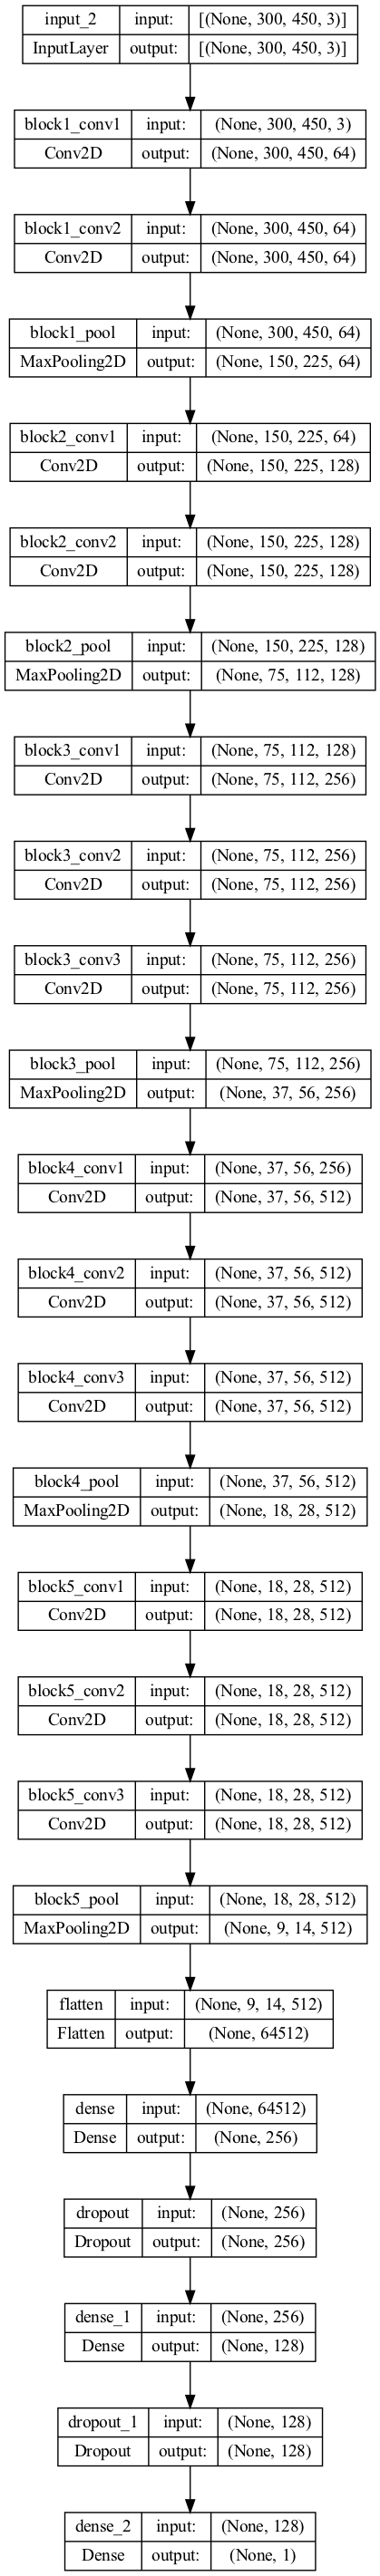

In [34]:
tf.keras.utils.plot_model(model, 'retinal_output_model.png', show_shapes=True, dpi=100)

In [35]:
history = model.fit(dataset_train,
                    validation_data=dataset_val,
                    epochs=15, 
                    verbose=1, 
                   callbacks=callback_lr)

Setting learning rate to 0.001
Epoch 1/15


2024-01-04 16:50:18.177092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 48s 48s/step - loss: 0.0598 - roc_metric: 0.4476 - pr_metric: 0.0264
Setting learning rate to 0.001
Epoch 2/15
1/1 [==============================] - 44s 44s/step - loss: 41.7369 - roc_metric: 0.5000 - pr_metric: 0.0156
Setting learning rate to 0.001
Epoch 3/15
1/1 [==============================] - 39s 39s/step - loss: 10.1025 - roc_metric: 0.2944 - pr_metric: 0.0210
Learning rate: 0.001
Epoch 4/15
1/1 [==============================] - 43s 43s/step - loss: 0.4588 - roc_metric: 0.6290 - pr_metric: 0.0625
Learning rate: 0.001
Epoch 5/15
1/1 [==============================] - 43s 43s/step - loss: 0.4634 - roc_metric: 0.4841 - pr_metric: 0.0143
Changing learning rate from 0.001 to 0.0007000000332482159
Epoch 6/15
1/1 [==============================] - 42s 42s/step - loss: 1.1471 - roc_metric: 0.5000 - pr_metric: 0.0156
Changing learning rate from 0.00070000003 to 0.0004900000232737511
Epoch 7/15
1/1 [==============================] - 40s 40s/step - 

In [36]:
from keras.models import model_from_json

model_archtecture = model.to_json()

with open('retinal_model_brvo.json', 'w') as json_file:
    json_file.write(model_archtecture)

model.save('./retinal_model_brvo')
model.save_weights('./retinal_model_brvo.h5')

INFO:tensorflow:Assets written to: ./retinal_model_brvo/assets


INFO:tensorflow:Assets written to: ./retinal_model_brvo/assets


## Predictions and ROC/PR curves on X_test

In [37]:
# preparation and preprocesing
X_test_path = X_test['filename'][:5]
y_test = X_test[:5].drop(['filename'], axis=1)
y_test = np.array(y_test).astype('float32')

print('shape of X_test:', X_test_path.shape)
print('shape of y_test:', y_test.shape)

X_test_img  = []
for filepath in tqdm(X_test_path):

  # Read and decode
  img = tf.io.read_file(filepath)
  img = tf.io.decode_png(img, channels=3)

  img = tf.py_function(extract_bv_wrapper, [img], tf.float32)
  img.set_shape([None, None, 3])

  #Resize
  img = scale_down(img)
  X_test_img.append([img])


shape of X_test: (5,)
shape of y_test: (5, 1)


100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


In [38]:
#transform to array numpy
X_test_img = np.array(X_test_img)
X_test_img = X_test_img[:,0,:,:]
X_test_img.shape

(5, 300, 450, 3)

In [39]:
y_pred = model.predict(X_test_img)

2024-01-04 17:03:53.733106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 976ms/step


In [40]:
from sklearn.metrics import roc_auc_score

auc_scores = []
for i in range(46):
  try:
    auc = roc_auc_score(y_test[:,i], y_pred[:,i])
    auc_scores.append(auc)
  except:
    pass


def Average(lst):
    return sum(lst) / len(lst)
  
avg_auc = Average(auc_scores)
  
# Printing average of the list
print("Average auc score available classes =", round(avg_auc, 2),'%')

Average auc score available classes = 0.5 %
